In [1]:
import time
start = time.time()

In [2]:
import sys
transformer_path = 'D:\FAST\FYP\FYP23-Deep-Document-Clustering\Transformer' # ==== Path for transformer folder
sys.path.insert(0, transformer_path)

In [3]:
import os
data_path = "D:/FAST/FYP/FYP23-Deep-Document-Clustering/data/" # ===== Path for data

In [4]:
import numpy as np
import pandas as pd
import nltk
import os
import warnings
from collections import defaultdict
from sklearn.metrics import confusion_matrix
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import Normalizer
from nltk.corpus import wordnet as wn, stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import silhouette_score
from sklearn.metrics.cluster import normalized_mutual_info_score as nmi_score
from sklearn.metrics import adjusted_rand_score as ari_score
from sklearn.metrics import f1_score 
from sklearn.cluster import SpectralClustering
from sklearn.decomposition import LatentDirichletAllocation
import pickle
import torch
import random
import matplotlib.pyplot as plt

from utils.Encoder import Encoder
from utils.PositionalEncoding import PositionalEncoding

os.environ['OMP_NUM_THREADS'] = '1'
warnings.filterwarnings("ignore", category=UserWarning, module="sklearn.cluster._kmeans")
warnings.filterwarnings("ignore", category=UserWarning, module="sklearn.feature_extraction.text")


c:\Users\Ali Ahmed\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
def reset_random_seeds(seed):
   os.environ['PYTHONHASHSEED']=str(seed)
   torch.manual_seed(seed)
   np.random.seed(seed)
   random.seed(seed)

def Purity_Score(label_seq, pred_labels):
    # Calculate the confusion matrix to compare true labels and cluster assignments
    confusion = confusion_matrix(label_seq, pred_labels)
    # Calculate the purity
    purity = np.sum(np.max(confusion, axis=0)) / np.sum(confusion)
    return purity

def Evaluate(X, true_labels, predicted_labels):
    purity = Purity_Score(true_labels, predicted_labels)
    silhouette = silhouette_score(X, predicted_labels, metric='euclidean')
    ari = ari_score(true_labels, predicted_labels)
    nmi = nmi_score(true_labels, predicted_labels)
    
    print(f"Purity: {purity}")
    print(f"Silhouette Score: {silhouette}")
    print(f"ARI Score: {ari}")
    print(f"NMI Score: {nmi}")

def SaveFeatures(X, file_name):
    pickle_path = open(file_name, 'wb')
    pickle.dump(X, pickle_path)
    pickle_path.close()

def ReadFeatures(file_name):
    pickle_read = open(file_name, 'rb')
    x = pickle.load(pickle_read)
    pickle_read.close()
    return x

In [6]:
os.chdir(data_path)

In [7]:
x = np.loadtxt('bbc.txt', dtype=float)
y = np.loadtxt('bbc_label.txt', dtype=int)

In [8]:
x = torch.tensor(x, dtype=torch.float32)

In [9]:
x.size()

torch.Size([2225, 9635])

In [10]:
d_model = 9635
num_heads = 1
drop_prob = 0.1
batch_size = 25
max_sequence_length = 2225
ffn_hidden = 2048
num_layers = 10

In [11]:
pe = PositionalEncoding(d_model=d_model, max_sequence_length=max_sequence_length)
positional_encoding = pe.forward()

In [12]:
positional_encoding = positional_encoding[:,0:-1]
positional_encoding.size()

torch.Size([2225, 9635])

In [13]:
x = x + positional_encoding

In [14]:
x = x.reshape(shape=(batch_size, x.size()[0] // batch_size, x.size()[1]))

In [15]:
x.size()

torch.Size([25, 89, 9635])

In [16]:
reset_random_seeds(42)

In [17]:
encoder = Encoder(d_model=d_model, ffn_hidden=ffn_hidden, num_heads=num_heads, drop_prob=drop_prob, num_layers=num_layers)

In [18]:
out = encoder(x)

x.size(): torch.Size([25, 89, 9635])
tensor([[[ 2.6300e-02,  1.0792e+00,  1.0320e-01,  ...,  0.0000e+00,
           1.0000e+00,  0.0000e+00],
         [ 8.4147e-01,  5.4030e-01,  8.9384e-01,  ...,  1.0029e-04,
           1.0000e+00,  1.0010e-04],
         [ 9.0930e-01, -3.4795e-01,  9.1088e-01,  ...,  2.0057e-04,
           1.0000e+00,  2.0019e-04],
         ...,
         [-9.2346e-01, -3.8370e-01, -8.4828e-01,  ...,  8.6246e-03,
           9.9996e-01,  8.6081e-03],
         [-8.2182e-01,  6.0655e-01, -9.0474e-01,  ...,  8.7249e-03,
           9.9996e-01,  8.7082e-03],
         [ 3.5398e-02,  9.9937e-01, -7.8789e-02,  ...,  8.8252e-03,
           9.9996e-01,  8.8083e-03]],

        [[ 8.6007e-01,  5.4248e-01,  8.1386e-01,  ...,  8.9254e-03,
           9.9996e-01,  8.9084e-03],
         [ 8.9400e-01, -4.1507e-01,  9.5746e-01,  ...,  9.0257e-03,
           9.9996e-01,  9.0085e-03],
         [ 1.0599e-01, -9.9437e-01,  2.7636e-01,  ...,  9.1260e-03,
           9.9996e-01,  9.1086e-03],
  

In [19]:
del encoder

In [20]:
def KMeans_Labels(X, n, rstate_limit, true_labels):
    # Specify the number of clusters (you can choose an appropriate value)
    num_clusters = n
    
    # find centoids which give maximum purity
    purity_collection = {}
    for i in range(rstate_limit):
        clusters = KMeans(n_init='auto', n_clusters=num_clusters, random_state=i, init='k-means++').fit(X).labels_
        purity_collection[i] = Purity_Score(true_labels, clusters)
    
    max_rand_state = max(purity_collection, key=purity_collection.get)
    print(f"Maximum purity of {purity_collection[max_rand_state]} found on random state {max_rand_state}")

    plot_graph(purity_collection.keys(), purity_collection.values())
    
    # Create a KMeans model
    kmeans = KMeans(n_init='auto', n_clusters=num_clusters, random_state=max_rand_state, init='k-means++')
    # Fit the KMeans model to the TF-IDF data
    kmeans.fit(X)
    # Get the cluster assignments for each document
    cluster_assignments = kmeans.labels_
    
    return cluster_assignments

def plot_graph(x, y):
    plt.scatter(x, y, marker = "o")
    plt.title("Purity x Random State")
    plt.ylabel("Purity")
    plt.xlabel("Random State")
    plt.show()

In [21]:
reshaped_out = out.reshape(out.size()[0] * out.size()[1], out.size()[2])

Maximum purity of 0.9568539325842697 found on random state 660


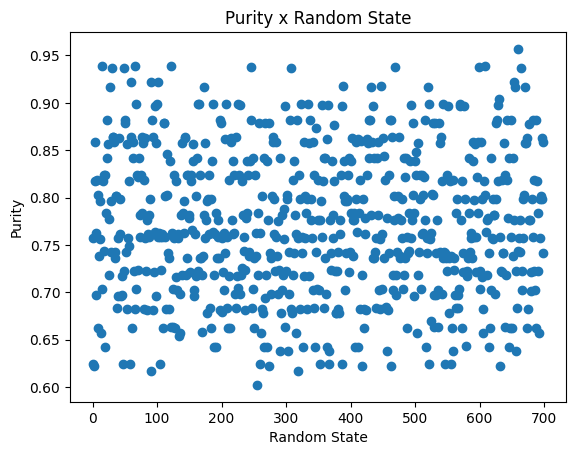

In [22]:
enhanced_x = reshaped_out.detach().numpy()
true_labels = y
pred_lables = KMeans_Labels(enhanced_x, 5, 700, true_labels)

In [23]:
Evaluate(enhanced_x, true_labels, pred_lables)

Purity: 0.9568539325842697
Silhouette Score: 0.11720018833875656
ARI Score: 0.8964100017894705
NMI Score: 0.8990337694021349


In [24]:
end = time.time()
time_taken = end - start

In [25]:
print(f"Time taken: {time_taken:.2f}s")

Time taken: 328.95s
